This tutorial is about **NATURAL LANGUAGE PROCESSING** (NLP) based on Peter Norvig notebook <br>

http://nbviewer.jupyter.org/url/norvig.com/ipython/How%20to%20Do%20Things%20with%20Words.ipynb

In [1]:
# Boring preliminaries
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


# 1 - Data: Text and Words

Before we can do things with words, we need some words. First we need some text, possibly from a file. Then we can break the text into words. I happen to have a big text called big.txt. We can read it, and see how big it is (in characters):

In [4]:
ls ngrams

TWL06.txt         count_1w.txt      count_big.txt     ngrams.py
ch14-old.pdf      count_2l.txt      enable1.txt       sowpods.txt
ch14.pdf          count_2w.txt      index.html        spell-errors.txt
count_1edit.txt   count_3l.txt      ngrams-test.txt


In [24]:
file = open('nlp_data/big.txt').read()
len(file)

564779

So, five hundreds thousand characters.

Now let's break the text up into words (or more formal-sounding, tokens). For now we'll ignore all the punctuation and numbers, and anything that is not a letter.

In [25]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower())

In [26]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [27]:
WORDS = tokens(file)
len(WORDS)

106274

So, a hundred words. Here are the first 10:

In [28]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


# 2 - Models: Bag of Words
The list WORDS is a list of the words in the TEXT, but it can also serve as a generative model of text. We know that language is very complicated, but we can create a simplified model of language that captures part of the complexity. 

In the bag of words model, we ignore the order of words, but maintain their frequency. Think of it this way: take all the words from the text, and throw them into a bag. Shake the bag, and then generating a sentence consists of pulling words out of the bag one at a time. Chances are it won't be grammatical or sensible, but it will have words in roughly the right proportions. 

Here's a function to sample an n word sentence from a bag of words:

In [30]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))


In [31]:
sample(WORDS)

'follow within of darker it been he from much small'

Another representation for a bag of words is a Counter, which is a dictionary of {'word': count} pairs. For example,

In [32]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'a': 2, 'is': 2, 'it': 1, 'test': 2, 'this': 1})

In [34]:
COUNTS = Counter(WORDS)
print(COUNTS.most_common(10))

[('the', 5654), ('i', 3038), ('and', 3024), ('to', 2752), ('of', 2674), ('a', 2647), ('in', 1771), ('that', 1752), ('it', 1735), ('you', 1504)]


In [36]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

5654 the
3 rare
3024 and
0 neverbeforeseen
46 words


In 1935, linguist George Zipf noted that in any big text, the nth most frequent word appears with a frequency of about 1/n of the most frequent word. He get's credit for Zipf's Law, even though Felix Auerbach made the same observation in 1913. If we plot the frequency of words, most common first, on a log-log plot, they should come out as a straight line if Zipf's Law holds. Here we see that it is a fairly close fit:

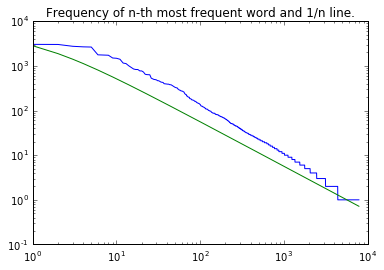

In [37]:
M = COUNTS['the']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

# 3 - Task: Spelling Correction

<br>
Given a word w, find the most likely correction c = correct(w).

Approach: Try all candidate words c that are known words that are near w. Choose the most likely one.

How to balance near and likely?

For now, in a trivial way: always prefer nearer, but when there is a tie on nearness, use the word with the highest WORDS count. Measure nearness by edit distance: the minimum number of deletions, transpositions, insertions, or replacements of characters. By trial and error, we determine that going out to edit distance 2 will give us reasonable results. Then we can define correct(w):

In [38]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)


In [41]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

Now for edits1(word): the set of candidate words that are one edit away. For example, given "wird", this would include "weird" (inserting an e) and "word" (replacing a i with a o), and also "iwrd" (transposing w and i; then known can be used to filter this out of the set of final candidates). How could we get them? One way is to split the original word in all possible places, each split forming a pair of words, (a, b), before and after the place, and at each place, either delete, transpose, replace, or insert a letter:

|  | | |  |  |  | |
| - | - | - | - | - | - | - |
| pairs: | Ø+wird | w+ird | wi+rd | wir+d | wird+Ø | Notes: (a, b) pair |
| deletions: | Ø+ird | w+rd | wi+d | wir+Ø | | Delete first char of b |
| transpositions: | Ø+iwrd | w+rid | wi+dr |  | | Swap first two chars of b |
| replacements: | Ø+?ird |w+?rd | wi+?d | wir+? | | Replace char at start of b |
| insertions: | Ø+?+wird | w+?+ird | wi+?+rd | wir+?+d | wird+?+Ø | Insert char between a and b |


In [52]:
def edits1(word):
    "Return all string that one edit away from this words"
    pairs = splits(word)
    deletions = [a + b[1:]                     for a,b in pairs if b]
    transposition = [a + b[1] + b[0] + b[2:]   for a,b in pairs if len(b)>1]
    replacements = [a + c + b[1:]              for a,b in pairs for c in alphabet]
    insertions = [a + c + b                    for a,b in pairs for c in alphabet]
    return set(deletions + transposition + replacements + insertions)


def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) for i in range(len(word)+1)]
   
alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [46]:
splits('wird')

[('', 'wird'), ('w', 'ird'), ('wi', 'rd'), ('wir', 'd'), ('wird', '')]

In [48]:
print(edits0('wird'))

{'wird'}


In [53]:
print(edits1('wird'))

{'rird', 'wirdp', 'wirdo', 'pwird', 'lird', 'wirdb', 'wiru', 'wirdh', 'awird', 'wirdy', 'pird', 'wxrd', 'wdird', 'wmird', 'wtrd', 'wirid', 'gwird', 'mird', 'wirqd', 'wirdk', 'wicd', 'qwird', 'wlrd', 'wirnd', 'qird', 'zird', 'kird', 'wimd', 'wisd', 'wirld', 'werd', 'wirp', 'wirdr', 'wcird', 'wyrd', 'nwird', 'wjird', 'wirod', 'uird', 'gird', 'wicrd', 'wirdj', 'wvird', 'wild', 'aird', 'wirds', 'wrrd', 'wfird', 'wfrd', 'wiqrd', 'wikd', 'wsird', 'wirvd', 'wigrd', 'wizrd', 'wirdn', 'wirbd', 'witrd', 'wirdc', 'wid', 'dird', 'winrd', 'zwird', 'wirrd', 'wixrd', 'wirf', 'wirtd', 'wgrd', 'wxird', 'wihrd', 'word', 'wnrd', 'wikrd', 'wzird', 'tird', 'wirdi', 'wilrd', 'vwird', 'wiord', 'wied', 'bwird', 'whird', 'wigd', 'wirdv', 'wyird', 'wirxd', 'xwird', 'wrird', 'wirm', 'wirh', 'whrd', 'wmrd', 'wirgd', 'wwrd', 'wifd', 'wirdu', 'wqird', 'wire', 'wirn', 'wirq', 'dwird', 'wirpd', 'woird', 'wibd', 'wirhd', 'wirs', 'wdrd', 'wircd', 'cwird', 'wiwrd', 'waird', 'fird', 'jwird', 'wjrd', 'wirdx', 'rwird', 'wi

In [55]:
print(len(edits2('wird')))


24254


In [66]:
list(map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')))

['seeing',
 'error',
 'in',
 'something',
 'whatever',
 'unusual',
 'mistaken',
 'everywhere']

Can we make the output prettier?

In [68]:
text = 'Speling errurs in somethink. Whutever; unusuel misteakes everyware?'

In [96]:
def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [103]:
list(map(case_of, ['UPPER', 'lower', 'Title', 'CamelCase']))

[<method 'upper' of 'str' objects>,
 <method 'lower' of 'str' objects>,
 <method 'title' of 'str' objects>,
 str]

In [98]:
correct_text('Speling Errurs IN somethink. Whutever; unusuel misteakes?')

'Seeing Error IN something. Whatever; unusual mistaken?'

In [104]:
correct_text('Audiance sayzs: tumblr ...')

'Advance says: tumbler ...'

So far so good. You can probably think of a dozen ways to make this better. Here's one: in the text "three, too, one, blastoff!" we might want to correct "too" with "two", even though "too" is in the dictionary. We can do better if we look at a sequence of words, not just an individual word one at a time. But how can we choose the best corrections of a sequence? The ad-hoc approach worked pretty well for single words, but now we could use some real theory ...

# 4 - Theory: From Counts to Probabilities of Word Sequences
<br>
We should be able to compute the probability of a word, P(w)P(w). We do that with the function pdist, which takes as input a Counter (hat is, a bag of words) and returns a function that acts as a probability distribution over all possible words. In a probability distribution the probability of each word is between 0 and 1, and the sum of the probabilities is 1.

In [150]:
def pdist(counter):
    
    "Make a probability distribution, given evidence from a Counter."
    # N = sum(counter.values())
    N = sum([i for i in counter.values()])
    print(N)
    print(counter['word'])
    return lambda x: counter[x]/N

P = pdist(COUNTS)

106274
40


In [151]:
for w in tokens('"The" is most common word in English'):
    print(P(w), w)

0.0532021002315 the
0.0106046634172 is
0.000856277170333 most
0.000131734949282 common
0.000376385569377 word
0.0166644710842 in
9.40963923443e-05 english


Now, what is the probability of a sequence of words? Use the definition of a joint probability:

$$ P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times P(w_3 \mid w_1 w_2) \times \ldots \times P(w_n \mid w_1 \ldots w_{n-1} ) $$

The bag of words model assumes that each word is drawn from the bag independently of the others. This gives us the wrong approximation:

$$ P(w_1 \ldots w_n) = P(w_1) \times P(w_2) \times P(w_3) \times \ldots \times P(w_n ) $$

The statistician George Box said that All models are wrong, but some are useful.

How can we compute $P(w_1 \ldots w_n)$? We'll use a different function name, $\text{Pwords}$, rather than $\text{P}$, and we compute the product of the individual probabilities:

In [157]:
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P(w) for w in words)

def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

In [158]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print(Pwords(tokens(test)), test)

6.93183071733e-11 this is a test
5.21808210274e-15 this is a unusual test
0.0 this is a neverbeforeseen test


Yikes—it seems wrong to give a probability of 0 to the last one; it should just be very small. We'll come back to that later. The other probabilities seem reasonable.

# 5 - Task: Word Segmentation

**Task:** <br>
Given a sequence of characters with no spaces separating words, recover the sequence of words.

Why? Languages with no word delimiters: 不带空格的词. <br>
In English, sub-genres with no word delimiters (spelling errors, URLs).

**Approach 1:** <br>
Enumerate all candidate segmentations and choose the one with highest Pwords

Problem: how many segmentations are there for an n-character text?

**Approach 2: ** <br>
Make one segmentation, into a first word and remaining characters. If we assume words are independent then we can maximize the probability of the first word adjoined to the best segmentation of the remaining characters.

    assert segment('choosespain') == ['choose', 'spain']

    segment('choosespain') ==
       max(Pwords(['c'] + segment('hoosespain')),
           Pwords(['ch'] + segment('oosespain')),
           Pwords(['cho'] + segment('osespain')),
           Pwords(['choo'] + segment('sespain')),
           ...
           Pwords(['choosespain'] + segment('')))


To make this somewhat efficient, we need to avoid re-computing the segmentations of the remaining characters. This can be done explicitly by dynamic programming or implicitly with memoization. Also, we shouldn't consider all possible lengths for the first word; we can impose a maximum length. What should it be? A little more than the longest word seen so far.

In [166]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [167]:
max(len(w) for w in COUNTS)

18

In [176]:
range(len(text))

67

In [177]:
text[66:]

'?'

In [179]:
def splits(text, start = 0, L = 20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) for i in range(start, min(len(text), L)+1)]

In [183]:
print(splits('word'))
print(splits('reallylongtext', 1, 4))

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [185]:
@memo
def segment(text):
    "Return a list of words that is the most probable segmentation of text."
    if not text:
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text,1))
        return max(candidates, key = Pwords)

In [186]:
segment('choosespain')

['choose', 's', 'pain']

In [187]:
segment('speedofart')

['speed', 'of', 'art']

In [188]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')

In [191]:
print(segment(decl))

['when', 'in', 'the', 'course', 'of', 'human', 'events', 'it', 'becomes', 'necessary', 'for', 'one', 'people', 'to', 'd', 'is', 'solve', 'the', 'political', 'bands', 'which', 'have', 'connected', 'them', 'with', 'another', 'and', 'to', 'assume', 'among', 'the', 'powers', 'of', 'the', 'earth', 'the', 'separate', 'and', 'equal', 'station', 'to', 'which', 'the', 'laws', 'of', 'nature', 'and', 'of', 'nature', 's', 'go', 'den', 'title', 'them']


In [192]:
Pwords(segment(decl))

8.6691021676551711e-154

In [193]:
Pwords(segment(decl * 2))

7.5153332393243606e-307

In [195]:
Pwords(segment(decl * 3))

0.0

That's a problem. We'll come back to it later.

In [197]:
segment('smallandinsignificant')

['small', 'and', 'in', 'significant']

In [198]:
segment('largeandinsignificant')

['large', 'and', 'in', 'significant']

In [199]:
print(Pwords(['large', 'and', 'insignificant']))
print(Pwords(['large', 'and', 'in', 'significant']))

0.0
1.72137739809e-12


### Summary:

* Looks pretty good!
* The bag-of-words assumption is a limitation.
* Recomputing Pwords on each recursive call is somewhat inefficient.
* Numeric underflow for texts longer than 100 or so words; we'll need to use logarithms, or other tricks.

# 6 - Data: Mo' Data, Mo' Better

Let's move up from millions to billions and billions of words. Once we have that amount of data, we can start to look at two word sequences, without them being too sparse. 
<br>I happen to have data files available in the format of "`word \t count`", and bigram data in the form of "`word1 word2 \t count`". Let's arrange to read them in:

In [200]:
def load_counts(filename, sep='\t'):
    """Return a Counter initialized from key-value pairs, 
    one on each line of filename."""
    C = Counter()
    for line in open(filename):
        key, count = line.split(sep)
        C[key] = int(count)
    return C

In [202]:
COUNTS1 = load_counts('nlp_data/count_1w.txt')
COUNTS2 = load_counts('nlp_data/count_2w.txt')

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)

588124220187
98671341
225955251755
0


In [207]:
print(len(COUNTS1), sum([i for i in COUNTS1.values()])/1e9)
print(len(COUNTS2), sum([i for i in COUNTS2.values()])/1e9)

333333 588.124220187
286358 225.955251755


In [208]:
COUNTS2.most_common(30)

[('of the', 2766332391),
 ('in the', 1628795324),
 ('to the', 1139248999),
 ('on the', 800328815),
 ('for the', 692874802),
 ('and the', 629726893),
 ('to be', 505148997),
 ('is a', 476718990),
 ('with the', 461331348),
 ('from the', 428303219),
 ('by the', 417106045),
 ('at the', 416201497),
 ('of a', 387060526),
 ('in a', 364730082),
 ('will be', 356175009),
 ('that the', 333393891),
 ('do not', 326267941),
 ('is the', 306482559),
 ('to a', 279146624),
 ('is not', 276753375),
 ('for a', 274112498),
 ('with a', 271525283),
 ('as a', 270401798),
 ('<S> and', 261891475),
 ('of this', 258707741),
 ('<S> the', 258483382),
 ('it is', 245002494),
 ('can be', 230215143),
 ('If you', 210252670),
 ('has been', 196769958)]

# 7 - Theory and Practice: Segmentation With Bigram Data

A less-wrong approximation:

$$ P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times P(w_3 \mid w_2) \times \ldots \times P(w_n \mid w_{n-1} ) $$

This is called the **bigram model**, and is equivalent to taking a text, cutting it up into slips of paper with two words on them, and having multiple bags, and putting each slip into a bag labelled with the first word on the slip. Then, to generate language, we choose the first word from the original single bag of words, and chose all subsequent words from the bag with the label of the previously-chosen word.

Let's start by defining the probability of a single discrete event, given evidence stored in a Counter:

Recall that the less-wrong bigram model approximation to English is:

$ P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times P(w_3 \mid w_2) \times \ldots \times P(w_n \mid w_{n-1} ) $

where the conditional probability of a word given the previous word is defined as:

$ P(w_n \mid w_{n-1}) = \frac{P(w_{n-1} w_n)}{P(w_{n-1})} $

In [219]:
[w for i,w in enumerate(tokens('this is a test'))]

['this', 'is', 'a', 'test']

In [221]:
def Pwords2(words, prev= '<S>'):
    "The probability of a sequence of words, using bigram data, given prev word."
    return product(cPword(w, prev if (i==0) else words[i-1]) for i, w in enumerate(words))

# Change Pwords to use P1w (the bigger dictionary) instead of Pword
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P1w(w) for w in words)

def cPword(word, prev):
    "Conditional probability of word, given previous word."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram)/P1w(prev)
    else: # Average the back-off value and zero.
        return P1w(word)

In [222]:
print(Pwords(tokens('this is a test')))
print(Pwords2(tokens('this is a test')))
print(Pwords2(tokens('is test a this')))

1.78739820006e-10
1.28273525888e-07
9.44228802937e-11


To make `segment2`, we copy `segment`, and make sure to pass around the previous token, and to evaluate probabilities with `Pwords2` instead of `Pwords`.

In [223]:
@memo
def segment2(text, prev='<S>'):
    "Return best segmentation of text; use bigram data." 
    if not text:
        return []
    else:
        candidates = ([first] + segment2(rest) 
                      for (first, rest) in splits(text,1))
        return max(candidates, key = lambda words: Pwords2(words, prev))

In [224]:
print(segment2('choosespain'))
print(segment2('speedofart'))
print(segment2('smallandinsignificant'))
print(segment2('largeandinsignificant'))

['choose', 'spain']
['speed', 'of', 'art']
['small', 'and', 'insignificant']
['large', 'and', 'insignificant']


In [225]:
adams = ('faroutintheunchartedbackwatersoftheunfashionableendofthewesternspiral' +
         'armofthegalaxyliesasmallunregardedyellowsun')
print(segment(adams))
print(segment2(adams))

['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']
['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']


In [226]:
P1w('unregarded')

0.0

In [227]:
tolkein = 'adrybaresandyholewithnothinginittositdownonortoeat'
print(segment(tolkein))
print(segment2(tolkein))

['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sitdown', 'on', 'or', 'to', 'eat']
['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sit', 'down', 'on', 'or', 'to', 'eat']


### Conclusion?
Bigram model is a little better, but not much. Hundreds of billions of words still not enough. (Why not trillions?) Could be made more efficient.

# 8 - Theory: Evaluation

So far, we've got an intuitive feel for how this all works. But we don't have any solid metrics that quantify the results. Without metrics, we can't say if we are doing well, nor if a change is an improvement. In general, when developing a program that relies on data to help make predictions, it is good practice to divide your data into three sets:

1. **Training set**: the data used to create our spelling model; this was the big.txt file.
2. **Development set**: a set of input/output pairs that we can use to rank the performance of our program as we are developing it.
3. **Test set**: another set of input/output pairs that we use to rank our program after we are done developing it. The development set can't be used for this purpose—once the programmer has looked at the development test it is tainted, because the programmer might modify the program just to pass the development test. That's why we need a separate test set that is only looked at after development is done.

For this program, the training data is the word frequency counts, the development set is the examples like "choosespain" that we have been playing with, and now we need a test set.

In [259]:
def test_segmenter(segmenter, tests):
    "Try segmenter on tests; report failures; return fraction correct."
    return sum([test_one_segment(segmenter, test) 
        for test in tests]), len(tests)

def test_one_segment(segmenter, test):
    words = tokens(test)
    result = segmenter(''.join(words))
    correct = (result == words)
    if not correct:
        print('expected', words)
        print('got     ', result)
    return correct

proverbs = ("""A little knowledge is a dangerous thing
  A man who is his own lawyer has a fool for his client
  All work and no play makes Jack a dull boy
  Better to remain silent and be thought a fool that to speak and remove all doubt;
  Do unto others as you would have them do to you
  Early to bed and early to rise, makes a man healthy, wealthy and wise
  Fools rush in where angels fear to tread
  Genius is one percent inspiration, ninety-nine percent perspiration
  If you lie down with dogs, you will get up with fleas
  Lightning never strikes twice in the same place
  Power corrupts; absolute power corrupts absolutely
  Here today, gone tomorrow
  See no evil, hear no evil, speak no evil
  Sticks and stones may break my bones, but words will never hurt me
  Take care of the pence and the pounds will take care of themselves
  Take care of the sense and the sounds will take care of themselves
  The bigger they are, the harder they fall
  The grass is always greener on the other side of the fence
  The more things change, the more they stay the same
  Those who do not learn from history are doomed to repeat it"""
  .splitlines())

In [260]:
test_segmenter(segment, proverbs)

expected ['sticks', 'and', 'stones', 'may', 'break', 'my', 'bones', 'but', 'words', 'will', 'never', 'hurt', 'me']
got      ['stick', 'sandstones', 'may', 'break', 'my', 'bones', 'but', 'words', 'will', 'never', 'hurt', 'me']


(19, 20)

In [261]:
test_segmenter(segment2, proverbs)

(20, 20)

This confirms that both segmenters are very good, and that segment2 is slightly better. There is much more that can be done in terms of the variety of tests, and in measuring statistical significance.

# 9 - Theory and Practice: Smoothing
Let's go back to a test we did before, and add some more test cases:

In [263]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a nongovernmental test',
         'this is a neverbeforeseen test',
         'this is a zqbhjhsyefvvjqc test']

for test in tests:
    print(Pwords(tokens(test)), test)

1.78739820006e-10 this is a test
3.78675425278e-15 this is a unusual test
1.31179474235e-16 this is a nongovernmental test
0.0 this is a neverbeforeseen test
0.0 this is a zqbhjhsyefvvjqc test


The issue here is the finality of a probability of zero. Out of the three 15-letter words, it turns out that "nongovernmental" is in the dictionary, but if it hadn't been, if somehow our corpus of words had missed it, then the probability of that whole phrase would have been zero. It seems that is too strict; there must be some "real" words that are not in our dictionary, so we shouldn't give them probability zero. There is also a question of likelyhood of being a "real" word. It does seem that "neverbeforeseen" is more English-like than "zqbhjhsyefvvjqc", and so perhaps should have a higher probability.

We can address this by assigning a non-zero probability to words that are not in the dictionary. This is even more important when it comes to multi-word phrases (such as bigrams), because it is more likely that a legitimate one will appear that has not been observed before.

We can think of our model as being overly spiky; it has a spike of probability mass wherever a word or phrase occurs in the corpus. What we would like to do is smooth over those spikes so that we get a model that does not depend on the details of our corpus. The process of "fixing" the model is called **smoothing**.

For example, Laplace was asked what's the probability of the sun rising tomorrow. From data that it has risen $n/n$ times for the last $n$ days, the maximum liklihood estimator is 1. But Laplace wanted to balance the data with the possibility that tomorrow, either it will rise or it won't, so he came up with $(n+1)/(n+2)$.

In [268]:
P1w = pdist(COUNTS1)
P1w('neverbeenseenbefore')

588124220187
98671341


0.0

If we use the previous probability without smoothing, then we get 0 probability. 

In [269]:
def pdist_additive_smoothed(counter, c=1):
    """The probability of word, given evidence from the counter.
    Add c to the count for each item, plus the 'unknown' item."""
    N = sum([i for i in counter.values()])          # Amount of evidence
    Nplus = N + c * (len(counter) + 1) # Evidence plus fake observations
    return lambda word: (counter[word] + c) / Nplus 

P1w = pdist_additive_smoothed(COUNTS1)

In [270]:
P1w('neverbeenseenbefore')

1.7003201005861308e-12

But, after we added some smoothing process, we get probability 1.7003201005861308e-12

But now there's a problem ... we now have previously-unseen words with non-zero probabilities. And maybe $10^{-12}$ is about right for words that are observed in text: that is, if I'm reading a new text, the probability that the next word is unknown might be around $10^{-12}$. But if I'm manufacturing 20-letter sequences at random, the probability that one will be a word is much, much lower than $10^{-12}$.

Look what happens:

In [272]:
segment('thisisatestofsegmentationofalongsequenceofwords')

['thisisatestofsegment', 'ationofalongsequence', 'of', 'words']

There are two problems:

First, we don't have a clear model of the unknown words. We just say "unknown" but we don't distinguish likely unknown from unlikely unknown. For example, is a 8-character unknown more likely than a 20-character unknown?

Second, we don't take into account evidence from parts of the unknown. For example, "unglobulate" versus "zxfkogultae".

For our next approach, Good - Turing smoothing re-estimates the probability of zero-count words, based on the probability of one-count words (and can also re-estimate for higher-number counts, but that is less interesting).

So, how many one-count words are there in COUNTS? (There aren't any in COUNTS1.) And what are the word lengths of them? Let's find out:

In [273]:
singletons = (w for w in COUNTS if COUNTS[w] == 1)

lengths = map(len, singletons)

Counter(lengths).most_common()

[(7, 620),
 (8, 598),
 (6, 532),
 (9, 448),
 (5, 396),
 (10, 300),
 (4, 209),
 (11, 169),
 (12, 85),
 (3, 52),
 (13, 36),
 (14, 20),
 (2, 6),
 (1, 2),
 (15, 2),
 (17, 2),
 (18, 1)]

In [279]:
lengths

In [277]:
1357 / sum([i for i in COUNTS.values()])

0.012768880441123887

RuntimeError: matplotlib does not support generators as input

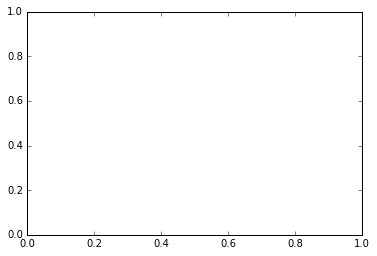

In [278]:
hist(lengths, bins=len(set(lengths)));

In [289]:
def pdist_good_turing_hack(counter, onecounter, base=1/26., prior=1e-8):
    """The probability of word, given evidence from the counter.
    For unknown words, look at the one-counts from onecounter, based on length.
    This gets ideas from Good-Turing, but doesn't implement all of it.
    prior is an additional factor to make unknowns less likely.
    base is how much we attenuate probability for each letter beyond longest."""
    N = sum([i for i in counter.values()])
    N2 = sum([i for i in onecounter.values()])
    lengths = map(len, [w for w in onecounter if onecounter[w] == 1])
    ones = Counter(lengths)
    longest = max(ones)
    return (lambda word: 
            counter[word] / N if (word in counter) 
            else prior * (ones[len(word)] / N2 or 
                          ones[longest] / N2 * base ** (len(word)-longest)))

# Redefine P1w
P1w = pdist_good_turing_hack(COUNTS1, COUNTS)

In [290]:
segment.cache.clear()
segment('thisisatestofsegmentationofaverylongsequenceofwords')

['this', 'isatestofsegment', 'ationofaverylong', 'sequence', 'of', 'words']

Above, I set the prior to 1e-8. And the result is not good. So, I changed the prior to 1e-12 and the result is better!

In [291]:
# Redefine P1w
P1w = pdist_good_turing_hack(COUNTS1, COUNTS, prior = 1e-12)
segment.cache.clear()
segment('thisisatestofsegmentationofaverylongsequenceofwords')

['this',
 'is',
 'a',
 'test',
 'of',
 'segmentation',
 'of',
 'a',
 'very',
 'long',
 'sequence',
 'of',
 'words']

That was somewhat unsatisfactory. We really had to crank up the prior, specifically because the process of running segment generates so many non-word candidates (and also because there will be fewer unknowns with respect to the billion-word WORDS1 than with respect to the million-word WORDS). It would be better to separate out the prior from the word distribution, so that the same distribution could be used for multiple tasks, not just for this one.

Now let's think for a short while about smoothing bigram counts. Specifically, what if we haven't seen a bigram sequence, but we've seen both words individually? For example, to evaluate P("Greenland") in the phrase "turn left at Greenland", we might have three pieces of evidence:

    P("Greenland")
    P("Greenland" | "at")
    P("Greenland" | "left", "at")


Presumably, the first would have a relatively large count, and thus large reliability, while the second and third would have decreasing counts and reliability. With interpolation smoothing we combine all three pieces of evidence, with a linear combination:

$P(w_3 \mid w_1 w_2)=c_1 P(w_3)+c_2 P(w_3 \mid w_2) + c_3 P(w_3 \mid w_1w_2)$

How do we choose $c_1,c_2,c_3$? By experiment: train on training data, maximize cc values on development data, then evaluate on test data.

However, when we do this, we are saying, with probability c1c1, that a word can appear anywhere, regardless of previous words. But some words are more free to do that than other words. Consider two words with similar probability:

In [293]:
print(P1w('francisco'))
print(P1w('individuals'))

7.73314623661e-05
7.72494966889e-05


They have similar unigram probabilities but differ in their freedom to be the second word of a bigram:

In [294]:
print([bigram for bigram in COUNTS2 if bigram.endswith('francisco')])

['San francisco', 'san francisco']


In [297]:
print([bigram for bigram in COUNTS2 if bigram.endswith('individuals')])

['or individuals', 'infected individuals', 'following individuals', 'the individuals', 'are individuals', 'which individuals', 'as individuals', 'more individuals', 'to individuals', 'for individuals', 'both individuals', 'minded individuals', 'many individuals', 'that individuals', 'on individuals', 'interested individuals', 'such individuals', 'those individuals', 'private individuals', 'qualified individuals', 'these individuals', 'in individuals', 'about individuals', 'two individuals', 'by individuals', 'and individuals', 'where individuals', '<S> individuals', 'certain individuals', 'For individuals', 'other individuals', 'healthy individuals', 'some individuals', 'among individuals', 'all individuals', 'from individuals', 'different individuals', 'between individuals', 'few individuals', 'with individuals', 'of individuals', 'These individuals', 'affected individuals', 'help individuals', 'income individuals']


Intuitively, words that appear in many bigrams before are more likely to appear in a new, previously unseen bigram. In Kneser-Ney smoothing (Reinhard Kneser, Hermann Ney) we multiply the bigram counts by this ratio. But I won't implement that here, because The Count never covered it.

# 10 - One More Task: Secret Codes

Let's tackle one more task: decoding secret codes. We'll start with the simplest of codes, a rotation cipher, sometimes called a shift cipher or a Caesar cipher (because this was state-of-the-art crypotgraphy in 100 BC). First, a method to encode:

In [300]:
def rot(msg, n=13): 
    "Encode a message with a rotation (Caesar) cipher." 
    return encode(msg, alphabet[n:]+alphabet[:n])

def encode(msg, key): 
    "Encode a message with a substitution cipher." 
    table = str.maketrans(upperlower(alphabet), upperlower(key))
    return msg.translate(table) 

def upperlower(text): return text.upper() + text.lower()  

In [301]:
rot('This is a secret message.', 1)

'Uijt jt b tfdsfu nfttbhf.'

In [303]:
rot('This is a secret message.')

'Guvf vf n frperg zrffntr.'

In [304]:
rot(rot('This is a secret message.'))

'This is a secret message.'

Now decoding is easy: try all 26 candidates, and find the one with the maximum Pwords:

In [305]:
def decode_rot(secret):
    "Decode a secret message that has been encoded with a rotation cipher."
    candidates = [rot(secret, i) for i in range(len(alphabet))]
    return max(candidates, key=lambda msg: Pwords(tokens(msg)))

In [314]:
msg = 'Who knows the answer?'
secret = rot(msg, 17)

print(secret)
print(decode_rot(secret))

Nyf befnj kyv rejnvi?
Who knows the answer?


Let's make it a tiny bit harder. When the secret message contains separate words, it is too easy to decode by guessing that the one-letter words are most likely "I" or "a". So what if the encode routine mushed all the letters together:

In [319]:
def encode(msg, key): 
    "Encode a message with a substitution cipher; remove non-letters." 
    msg = ''.join(tokens(msg))  ## Change here
    table = str.maketrans(upperlower(alphabet), upperlower(key))
    return msg.translate(table) 

Now we can decode by segmenting. We change candidates to be a list of segmentations, and still choose the candidate with the best Pwords:

In [317]:
def decode_rot(secret):
    """Decode a secret message that has been encoded with a rotation cipher,
    and which has had all the non-letters squeezed out."""
    candidates = [segment(rot(secret, i)) for i in range(len(alphabet))]
    return max(candidates, key=lambda msg: Pwords(msg))

In [320]:
msg = 'Who knows the answer this time? Anyone? Bueller?'
secret = rot(msg, 19)

print(secret)
print(decode_rot(secret))

pahdghplmaxtglpxkmablmbfxtgrhgxunxeexk
['who', 'knows', 'the', 'answer', 'this', 'time', 'anyone', 'bueller']


In [322]:
candidates = [segment(rot(secret, i)) for i in range(len(alphabet))]

for c in candidates:
    print(c, Pwords(c))

['pahdghplmaxtglpxkm', 'ablmbfxtgrhgxunxeexk'] 1.30978270003e-37
['qbiehiqmnbyuhmqyln', 'bcmncgyuhsihyvoyffyl'] 1.30978270003e-37
['rcjfijrnoczvinrzmocd', 'no', 'dhzvitjizwpzggzm'] 1.41080999679e-37
['sdkgjksopdawjosa', 'npdeopeiawjukjaxqahh', 'an'] 2.28573007724e-37
['tel', 'hkltpqebxkptboqe', 'fpqfjbxkvlkbyrbiibo'] 2.38095770817e-37
['ufmilmuqrfcylqucpr', 'fgqrgkcylwmlczscjjcp'] 1.30978270003e-37
['vgnjmnvrsgdzmrvdqs', 'ghrshldzmxnmdatdkkdq'] 1.30978270003e-37
['who', 'knows', 'the', 'answer', 'this', 'time', 'anyone', 'bueller'] 7.18422540159e-29
['xiplopxtuifbotxfsu', 'ijtujnfbozpofcvfmmfs'] 1.30978270003e-37
['yjqmpqyuvjgcpuygtv', 'jkuvkogcpaqpgdwgnngt'] 1.30978270003e-37
['zkrnqrzvwkhdqvzhuw', 'klvwlphdqbrqhexhoohu'] 1.30978270003e-37
['also', 'rsawxlierwaivxlm', 'wxmqiercsrifyippiv'] 6.27753124448e-35
['bmtpstbxymjfsxbjwy', 'mnxynrjfsdtsjgzjqqjw'] 1.30978270003e-37
['cnuqtucyznkgtyckxz', 'no', 'yzoskgteutkhakrrkx'] 1.41080999679e-37
['do', 'vruvdzaolhuzdlya', 'opzaptlhufvuliblss

What about a general substitution cipher? The problem is that there are 26! substitution ciphers, and we can't enumerate all of them. We would need to search through this space. Initially make some guess at a substitution, then swap two letters; if that looks better keep going, if not try something else. This approach solves most substitution cipher problems, although it can take a few minutes on a message of length 100 words or so.

